### 10-701 Machine Learning Project
# Image Caption Generation

Team 26  
Olivier Filion  
Michael Agaby  
Nicholas Amano  

All Imports: I'm copy pasting all imports here to stay organized

In [4]:
import sys
print(sys.version)
import json
import os
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from collections import defaultdict
import statistics

3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]


## Utility Functions

In [5]:
import json
import os

def load_captions(path):
    with open(path, "r") as json_file:
        json_dict = json.load(json_file)
    captions = {}
    for annotation in json_dict["annotations"]:
        image_id = annotation["image_id"]
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(annotation["caption"])
    return captions

train_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_train2017.json"))
val_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_val2017.json"))
print(val_captions[139]) 

['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']


In [6]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")
def preprocess_captions(captions):
    preprocessed_captions = {}
    for image_id in captions:
        preprocessed_captions[image_id] = []
        for caption in captions[image_id]:
            caption = "<start> " + caption.lower().strip() + " <end>"
            caption = tokenizer(caption)
            preprocessed_captions[image_id].append(caption)
    return preprocessed_captions

preprocessed_train_captions = preprocess_captions(train_captions)
preprocessed_val_captions = preprocess_captions(val_captions)
print(preprocessed_val_captions[139])

[['<start>', 'a', 'woman', 'stands', 'in', 'the', 'dining', 'area', 'at', 'the', 'table', '.', '<end>'], ['<start>', 'a', 'room', 'with', 'chairs', ',', 'a', 'table', ',', 'and', 'a', 'woman', 'in', 'it', '.', '<end>'], ['<start>', 'a', 'woman', 'standing', 'in', 'a', 'kitchen', 'by', 'a', 'window', '<end>'], ['<start>', 'a', 'person', 'standing', 'at', 'a', 'table', 'in', 'a', 'room', '.', '<end>'], ['<start>', 'a', 'living', 'area', 'with', 'a', 'television', 'and', 'a', 'table', '<end>']]


In [7]:
from torchtext.vocab import build_vocab_from_iterator

def create_vocabulary(tokenized_captions):
    all_tokens = []
    for image_id in tokenized_captions:
        for caption in tokenized_captions[image_id]:
            all_tokens += caption
    return build_vocab_from_iterator([all_tokens], min_freq=1, specials=["<unk>"])

vocabulary = create_vocabulary(preprocessed_train_captions)
print(len(vocabulary))

28939


In [8]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize, CenterCrop
from functools import lru_cache

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

class CaptionDataset(Dataset):

    def __init__(self, image_folder, preprocessed_captions, vocab):
        self.image_folder = image_folder
        self.captions = preprocessed_captions
        self.vocab = vocab
        self.indices = [(image_id, caption_id)
                        for image_id in preprocessed_captions
                        for caption_id in range(len(preprocessed_captions[image_id]))]
        self.tensor_transform = ToTensor()
        self.scale_transform = Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    
    def __len__(self):
        return len(self.indices)

    @lru_cache(maxsize=128)
    def _get_image(self, image_id, crop_and_scale):
        image_str = str(image_id)
        image_filename = "0" * (12 - len(image_str)) + image_str + ".jpg"
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path)

        if crop_and_scale:
            crop_transform = CenterCrop((min(image.size), min(image.size)))
            image = crop_transform(image)
            image = self.scale_transform(image)
        return self.tensor_transform(image)

    def __getitem__(self, idx, crop_and_scale=True):
        image_id, caption_id = self.indices[idx]
        
        image_tensor = self._get_image(image_id, crop_and_scale)

        caption = self.captions[image_id][caption_id]
        labels = torch.zeros((len(caption), 1))
        for i, token in enumerate(caption):
            token = token if token in self.vocab else "<unk>"
            labels[i][0] = self.vocab[token]

        return image_tensor, labels
  

# Visualizing Some Data

torch.Size([3, 256, 256])
tensor([[3.0000e+00],
        [1.0000e+00],
        [3.5700e+02],
        [3.8150e+03],
        [9.0000e+00],
        [1.0000e+00],
        [8.4000e+01],
        [1.2300e+02],
        [7.0000e+00],
        [4.1000e+01],
        [1.0860e+03],
        [4.0000e+00],
        [2.0000e+00]])
['<start>', 'a', 'bicycle', 'replica', 'with', 'a', 'clock', 'as', 'the', 'front', 'wheel', '.', '<end>']


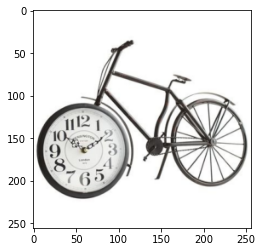

In [9]:
import matplotlib.pyplot as plt

train_ds = CaptionDataset(os.path.join("dataset", "train", "train2017"), preprocessed_train_captions, vocabulary)

im, l = train_ds[0]
print(im.shape)
print(l)

print(preprocessed_train_captions[train_ds.indices[0][0]][train_ds.indices[0][1]])

plt.imshow(im.permute((1, 2, 0)))
plt.show()

['<start>', 'a', 'car', 'that', 'seems', 'to', 'be', 'parked', 'illegally', 'behind', 'a', 'legally', 'parked', 'car', '<end>']
['<start>', 'two', 'cars', 'parked', 'on', 'the', 'sidewalk', 'on', 'the', 'street', '<end>']
['<start>', 'city', 'street', 'with', 'parked', 'cars', 'and', 'a', 'bench', '.', '<end>']
['<start>', 'cars', 'try', 'to', 'maneuver', 'into', 'parking', 'spaces', 'along', 'a', 'densely', 'packed', 'city', 'street', '.', '<end>']
['<start>', 'a', 'couple', 'of', 'cars', 'parked', 'in', 'a', 'busy', 'street', 'sidewalk', '.', '<end>']


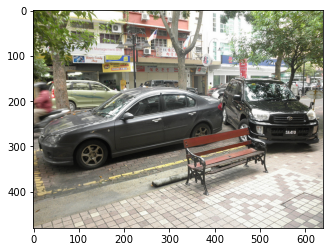

In [10]:
# an example of all 5 captions for one image
im, l = train_ds.__getitem__(10, False)
print(preprocessed_train_captions[train_ds.indices[10][0]][0])
print(preprocessed_train_captions[train_ds.indices[10][0]][1])
print(preprocessed_train_captions[train_ds.indices[10][0]][2])
print(preprocessed_train_captions[train_ds.indices[10][0]][3])
print(preprocessed_train_captions[train_ds.indices[10][0]][4])
plt.imshow(im.permute((1, 2, 0)))
plt.show()

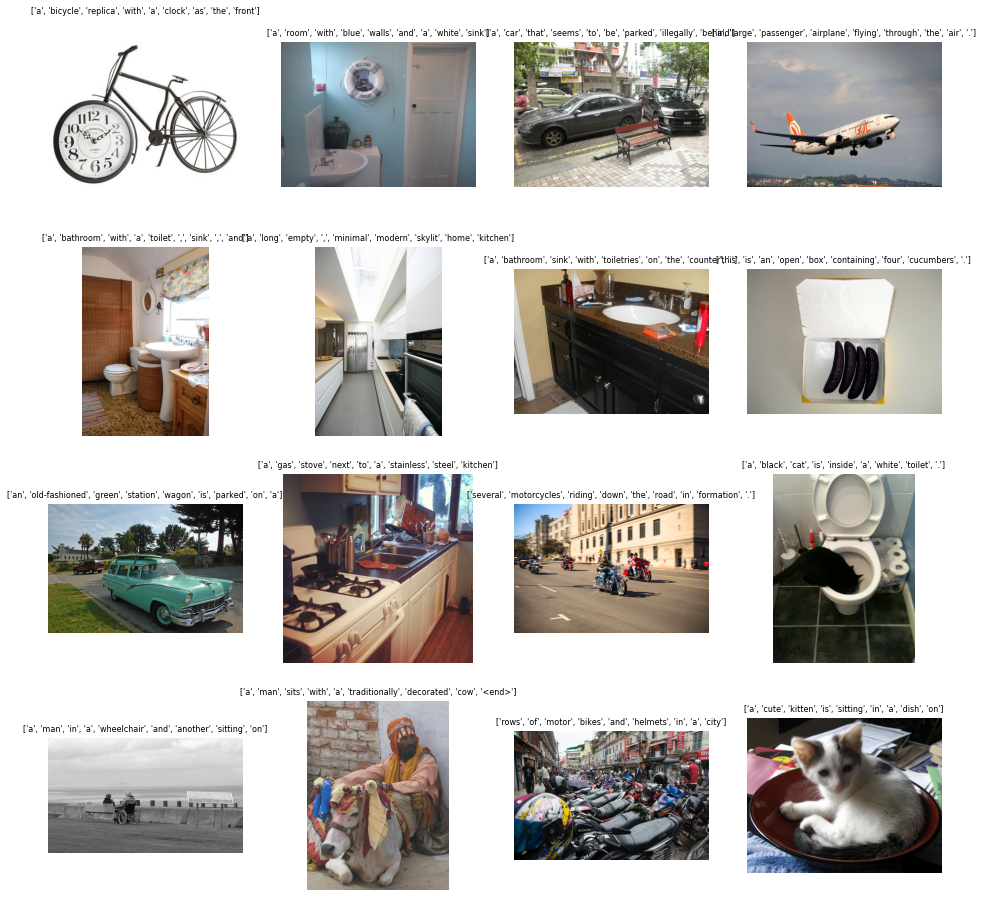

In [11]:
# 16 images as well as the first few wordsw of one of their captions
plt.subplots(figsize=(16,16))

for i in range(16):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(4,4,i+1)
    plt.title(preprocessed_train_captions[train_ds.indices[5*i][0]][0][1:10], fontsize=8)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

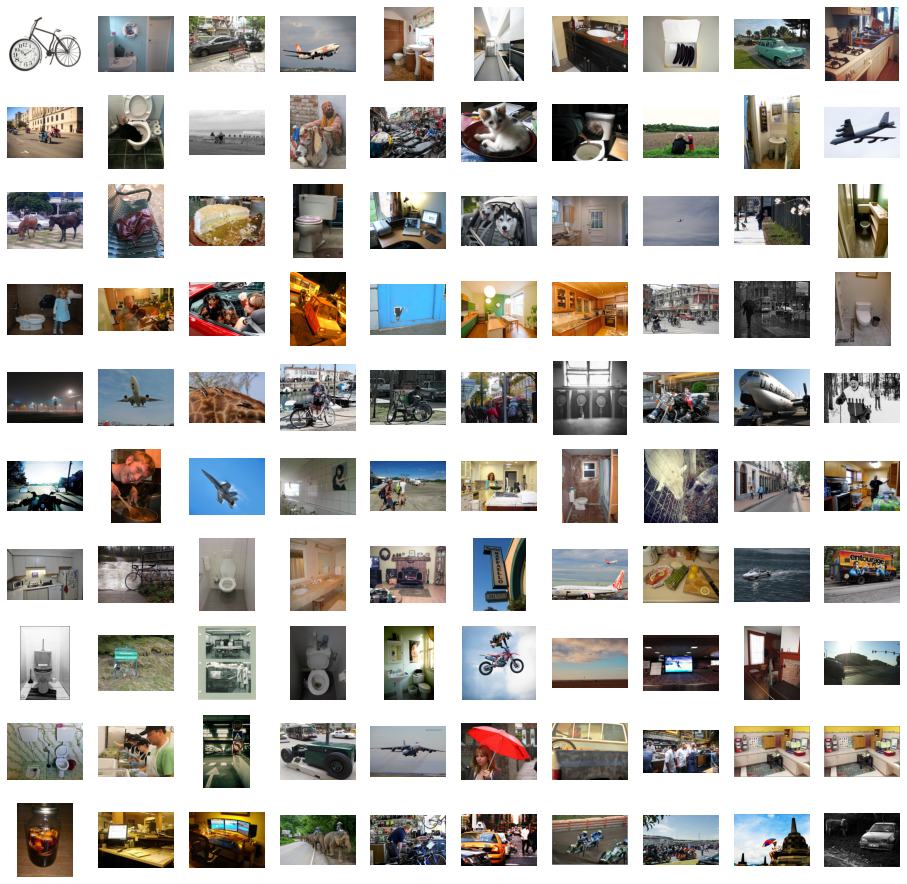

In [12]:
# first 100 images:
plt.subplots(figsize=(16,16))

for i in range(100):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(10,10,i+1)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

### Aspect Ratios

Estimating the histogram of aspect ratios by random sampling

0
10000
20000
30000
40000


(array([ 18.,  45., 138., 184., 135., 148., 122., 110., 128., 123.,  68.,
         49.,  34.,  32.,  23.,  19.,  17.,  12.,   9.,   9.,   6.,  10.,
          6.,   3.,   3.,   6.,   4.,   3.,   1.,   1.,   1.,   3.,   2.,
          2.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.]),
 array([0.3109375 , 0.43525471, 0.55957191, 0.68388912, 0.80820632,
        0.93252353, 1.05684073, 1.18115794, 1.30547514, 1.42979235,
        1.55410955, 1.67842676, 1.80274396, 1.92706117, 2.05137838,
        2.17569558, 2.30001279, 2.42432999, 2.5486472 , 2.6729644 ,
        2.79728161, 2.92159881, 3.04591602, 3.17023322, 3.29455043,
        3.41886764, 3.54318484, 3.66750205, 3.79181925, 3.91613646,
        4.04045366, 4.16477087, 4.28908807, 4.41340528, 4.53772248,
        4.66203969, 4.78635689, 4.9106741 , 5.03499131, 5.15930851,
        5.28362572, 5.40794292, 5.53226013, 5.65657733, 5.78089454,
        5.90521174, 6.02952895, 6.15384615]),
 <BarContainer obj

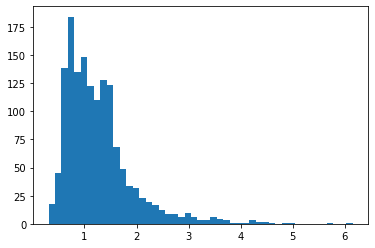

In [13]:
from collections import defaultdict
import random

ratios = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[w/h]+=1
plt.hist(ratios, bins='auto') 

### Area

Estimating histogram of area by random sampling


0
10000
20000
30000
40000


(array([1482.,   22.,   32.,   44.,   79.,  135.,  114.,  119.,  109.,
         106.,   66.,   51.,   47.,   44.,   46.,   42.]),
 array([3.10937500e-01, 2.56002915e+04, 5.12002721e+04, 7.68002526e+04,
        1.02400233e+05, 1.28000214e+05, 1.53600194e+05, 1.79200175e+05,
        2.04800155e+05, 2.30400136e+05, 2.56000117e+05, 2.81600097e+05,
        3.07200078e+05, 3.32800058e+05, 3.58400039e+05, 3.84000019e+05,
        4.09600000e+05]),
 <BarContainer object of 16 artists>)

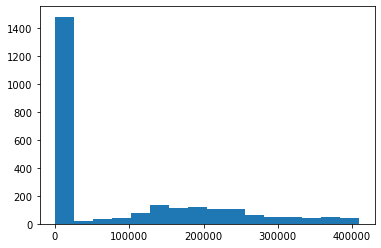

In [14]:
areas = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[h*w]+=1
plt.hist(ratios, bins='auto') 

### Finding the most common words 

In [15]:
counts = defaultdict(int)

for captions in preprocessed_train_captions.values():
    for caption in captions:
        for word in caption:
            counts[word]+=1
        
    

In [16]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
conjuncts = ['has','small','while','some','down','to','<start>','<end>','a','.','on','of','the','in','with','and', 'is', 'an', 'two', 'one', 'at', 'are', 'next'
            ,'there','side','other','is', 'it', 'that','near', 'the', 'his', 'her', 'they', 'up', 'top', ',', ':', ';', '\''
            ,'by','large','front','back']

for word in conjuncts:
    if(word in sorted_counts):
        sorted_counts.remove(word)
    
print(sorted_counts[0:50])

['man', 'sitting', 'standing', 'people', 'white', 'woman', 'street', 'table', 'holding', 'person', 'group', 'field', 'tennis', 'black', 'train', 'plate', 'room', 'dog', 'riding', 'red', 'cat', 'young', 'water', 'baseball', 'playing', 'walking', 'bathroom', 'sign', 'blue', 'kitchen', 'food', 'grass', 'bus', 'pizza', 'green', 'parked', 'building', 'bed', 'looking', 'snow', 'beach', 'ball', 'couple', 'three', 'for', 'boy', 'men', 'toilet', 'clock', 'city']


### Distribution of caption lengths

Average caption length:  11.312297529543576
Median caption length:  11
Shortest caption length:  6
Longest caption length:  57


(array([2.29900e+03, 2.96990e+04, 1.02419e+05, 1.22734e+05, 1.14209e+05,
        8.22360e+04, 5.38810e+04, 3.22070e+04, 1.87450e+04, 1.11910e+04,
        7.09100e+03, 4.47500e+03, 2.90500e+03, 2.04300e+03, 1.45500e+03,
        9.81000e+02, 7.50000e+02, 5.79000e+02, 3.89000e+02, 2.78000e+02,
        2.18000e+02, 1.66000e+02, 1.12000e+02, 9.60000e+01, 8.30000e+01,
        5.80000e+01, 4.30000e+01, 5.60000e+01, 3.90000e+01, 3.40000e+01,
        4.10000e+01, 2.70000e+01, 2.20000e+01, 2.20000e+01, 1.00000e+01,
        9.00000e+00, 2.50000e+01, 1.80000e+01, 1.90000e+01, 1.50000e+01,
        1.30000e+01, 1.40000e+01, 8.00000e+00, 9.00000e+00, 1.00000e+01,
        7.00000e+00, 5.00000e+00, 1.00000e+00, 2.00000e+00, 5.00000e+00]),
 array([ 6.  ,  7.02,  8.04,  9.06, 10.08, 11.1 , 12.12, 13.14, 14.16,
        15.18, 16.2 , 17.22, 18.24, 19.26, 20.28, 21.3 , 22.32, 23.34,
        24.36, 25.38, 26.4 , 27.42, 28.44, 29.46, 30.48, 31.5 , 32.52,
        33.54, 34.56, 35.58, 36.6 , 37.62, 38.64, 39.66

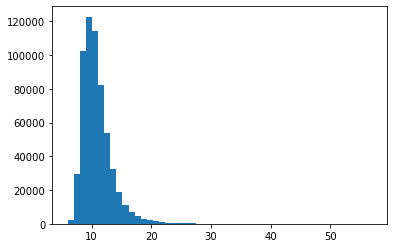

In [25]:
import statistics
lengths = []
for captions in preprocessed_train_captions.values():
    for caption in captions:
        lengths.append(len(caption)-2)
        
print("Average caption length: ", sum(lengths)/len(lengths))
print("Median caption length: ", statistics.median(lengths))
print("Shortest caption length: ", min(lengths))
print("Longest caption length: ", max(lengths))
plt.hist(lengths, bins=50) 

We see a clear right skew in the distribution of caption lengths